In [2]:
install.packages("tidyverse")

also installing the dependencies ‘cellranger’, ‘selectr’, ‘haven’, ‘lubridate’, ‘modelr’, ‘readr’, ‘readxl’, ‘reprex’, ‘rvest’





The downloaded binary packages are in
	/var/folders/z4/zq1sx9z918l822zf41yhflvr0000gn/T//RtmpMVWmHf/downloaded_packages


In [4]:
install.packages("pheatmap")


The downloaded binary packages are in
	/var/folders/z4/zq1sx9z918l822zf41yhflvr0000gn/T//RtmpMVWmHf/downloaded_packages


In [5]:
install.packages("RColorBrewer")


The downloaded binary packages are in
	/var/folders/z4/zq1sx9z918l822zf41yhflvr0000gn/T//RtmpMVWmHf/downloaded_packages


In [6]:
install.packages("ggrepel")


The downloaded binary packages are in
	/var/folders/z4/zq1sx9z918l822zf41yhflvr0000gn/T//RtmpMVWmHf/downloaded_packages


In [7]:
BiocManager::install("recount")

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'recount'

also installing the dependencies ‘rngtools’, ‘doRNG’, ‘bumphunter’, ‘derfinderHelper’, ‘GenomicFiles’, ‘qvalue’, ‘derfinder’, ‘downloader’, ‘GEOquery’, ‘rentrez’





The downloaded binary packages are in
	/var/folders/z4/zq1sx9z918l822zf41yhflvr0000gn/T//RtmpMVWmHf/downloaded_packages


Old packages: 'KernSmooth', 'codetools', 'nlme'



In [18]:
BiocManager::install("apeglm")

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'apeglm'

also installing the dependencies ‘numDeriv’, ‘bdsmatrix’, ‘mvtnorm’, ‘coda’, ‘bbmle’, ‘emdbook’, ‘RcppEigen’, ‘RcppNumerical’





The downloaded binary packages are in
	/var/folders/z4/zq1sx9z918l822zf41yhflvr0000gn/T//RtmpMVWmHf/downloaded_packages


Old packages: 'KernSmooth', 'codetools', 'nlme'



In [19]:
library(apeglm)

In [8]:
library(tidyverse)
library(DESeq2)
library(recount)
library(pheatmap)
library(RColorBrewer)
library(ggrepel)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The follow

In [9]:
get_recount_data <- function(projectid) {
  recount::download_study(projectid)
  load(file.path(projectid, "rse_gene.Rdata"),
                envir = .GlobalEnv)
}
get_recount_data("SRP018779")


2020-11-23 11:23:09 downloading file rse_gene.Rdata to SRP018779



In [10]:
#Extract case/control status
colData(rse_gene)$case <- colData(rse_gene)$characteristics %>% 
  as.list() %>% 
  map_chr(function(x) ifelse(any(grepl("control", x)),
                             "control",
                             "case"))
#make control the base level
colData(rse_gene)$case <- factor(colData(rse_gene)$case, 
                                 levels = c("control", "case"))

There are 3 main steps that I like to consider: exploratory data analysis, the analysis, and the visualization.We first have to build a DESeqDataSet object to use in our analysis. This object essentially contains three components: colData contains info about the samples, rowRanges contains info about the genomic ranges and assay contains the matrix of counts.

In [20]:
rse_gene

class: RangedSummarizedExperiment 
dim: 58037 6 
metadata(0):
assays(1): counts
rownames(58037): ENSG00000000003.14 ENSG00000000005.5 ...
  ENSG00000283698.1 ENSG00000283699.1
rowData names(3): gene_id bp_length symbol
colnames(6): SRR748302 SRR748303 ... SRR748306 SRR748307
colData names(22): project sample ... characteristics case

In [12]:
dds <- DESeq2::DESeqDataSet(rse_gene, design = ~ case)

converting counts to integer mode



          SRR748302 SRR748303 SRR748304 SRR748305 SRR748306
SRR748303  15.96889                                        
SRR748304  16.35189  18.94082                              
SRR748305  18.63954  21.70521  19.13209                    
SRR748306  18.90885  21.01824  19.89167  17.07292          
SRR748307  16.37873  19.56717  17.86773  15.29234  16.33646

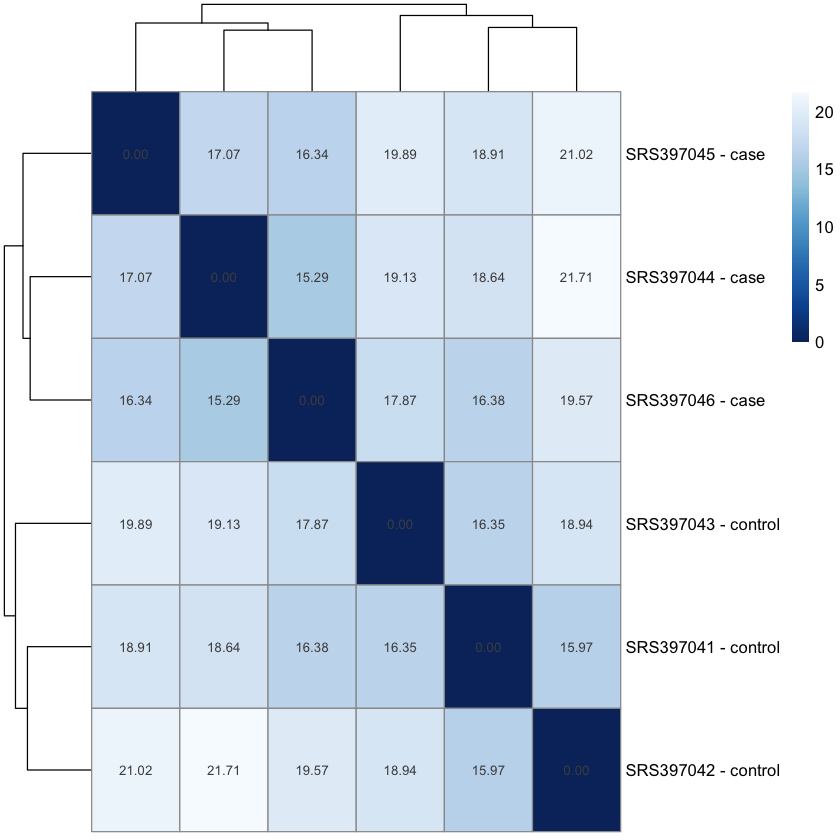

In [13]:
#First, we can assess overall similarity between samples using Euclidean distance.
vst_data <- vst(dds, blind = F) #apply variance-stabilizing transformation

sample_dists <- dist(t(assay(vst_data))) #compute Euclidean distances
sample_dists
sample_dists_mat <- as.matrix(sample_dists)
rownames(sample_dists_mat) <- paste(vst_data$sample, vst_data$case, sep = " - ")
colnames(sample_dists_mat) <- NULL
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
pheatmap(sample_dists_mat,
         clustering_distance_rows = sample_dists,
         clustering_distance_cols = sample_dists,
         col = colors, 
         display_numbers = T)

Another way to assess similarity between samples is to use a principal component analysis (PCA) plot. Without going into too much detail, it’s essentially a plot where the x-axis explains most of the differences between all the samples, and the y-axis explains the second-most differences between all the samples.

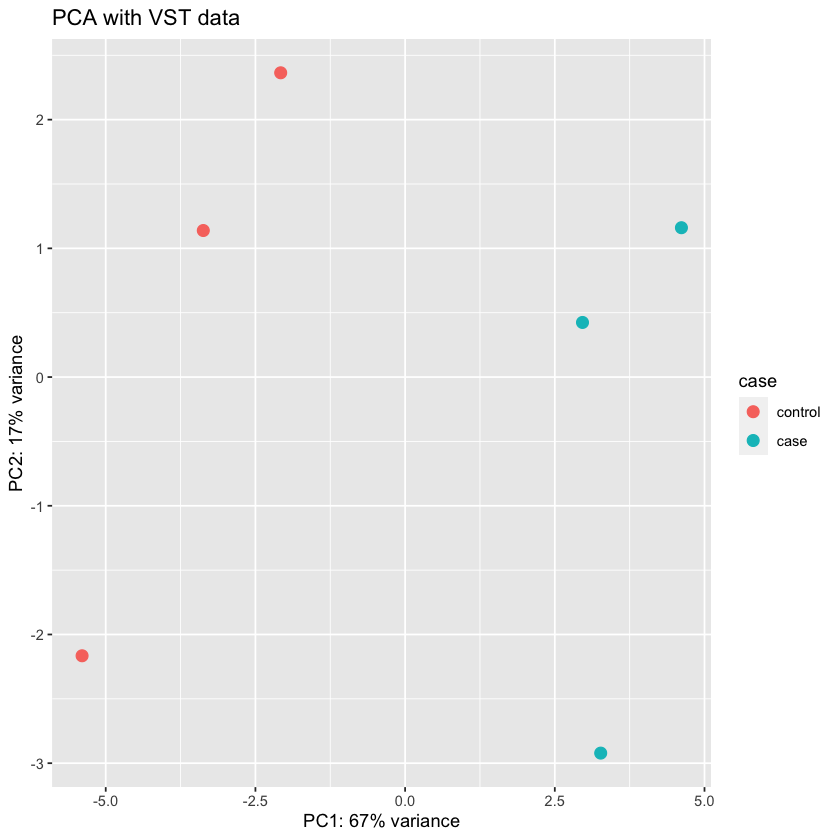

In [14]:
pca_dat <- DESeq2::plotPCA(vst_data, intgroup = "case", returnData = T)
percentvar <- round(100 * attr(pca_dat, "percentVar"))
ggplot(pca_dat, aes(x = PC1, y = PC2, color = case)) +
  geom_point(size = 3) +
  xlab(paste0("PC1: ", percentvar[1], "% variance")) +
  ylab(paste0("PC2: ", percentvar[2], "% variance")) +
  ggtitle("PCA with VST data")

Now that we’ve visualized our data, let’s run the analysis.DESeq2 performs for each gene a hypothesis test to see whether evidence is sufficient to decide against the null hypothesis that there is zero effect of the treatment on the gene and that the observed difference between treatment and control was merely caused by experimental variability.

In [15]:
de_data <- DESeq(dds)
res <- results(de_data)
summary(res)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 44988 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1266, 2.8%
LFC < 0 (down)     : 1115, 2.5%
outliers [1]       : 7210, 16%
low counts [2]     : 3300, 7.3%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



One useful thing we can do is visualize the distribution of estimated coefficients in the model across all the genes. We can use an MA plot. The log2 fold change (LFC) for a particular comparison is plotted on the y-axis and the average of the counts normalized by size factor is shown on the x-axis. Each gene is represented with a dot. Before making the MA-plot, we use the lfcShrink function to shrink the log2 fold changes for the comparison of cases vs controls. There are three types of shrinkage estimators in DESeq2, which are covered in the DESeq2 vignette

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



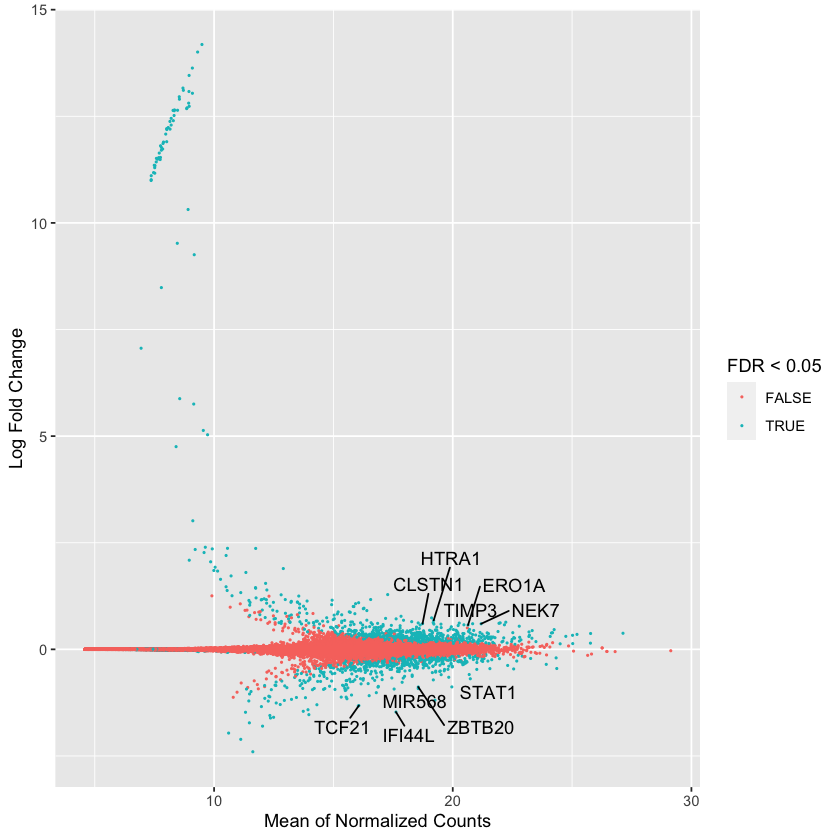

In [21]:
dds_shrink <- DESeq2::lfcShrink(de_data, coef = "case_case_vs_control")
res_shrink <- dds_shrink %>%
  as.data.frame() %>%
  rownames_to_column("GeneID") %>%
  left_join(mcols(dds) %>% 
              as_tibble() %>%
              dplyr::select(gene_id, symbol), by = c("GeneID" = "gene_id")) %>%
  dplyr::rename(logFC = log2FoldChange,
                FDR = padj) %>%
  drop_na(pvalue,FDR) %>%
  mutate(GeneID = gsub("\\..*", "", GeneID))
  
  plot_MA <- function(data, names_to_display) {
  cutoff <- sort(data$pvalue)[names_to_display]
  data <- data %>%
    mutate(topgenelabel = ifelse(pvalue <= cutoff, symbol, ""),
           GeneID = gsub("\\..*", "", GeneID))
  ggplot(data, aes(x = log2(baseMean), y = logFC)) + 
    geom_point(aes(col = FDR < 0.05), shape = 20, size = 0.5) + 
    ggrepel::geom_text_repel(aes(label = topgenelabel)) + 
    labs(x = "Mean of Normalized Counts",
         y = "Log Fold Change")
}

plot_MA(res_shrink, 10)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



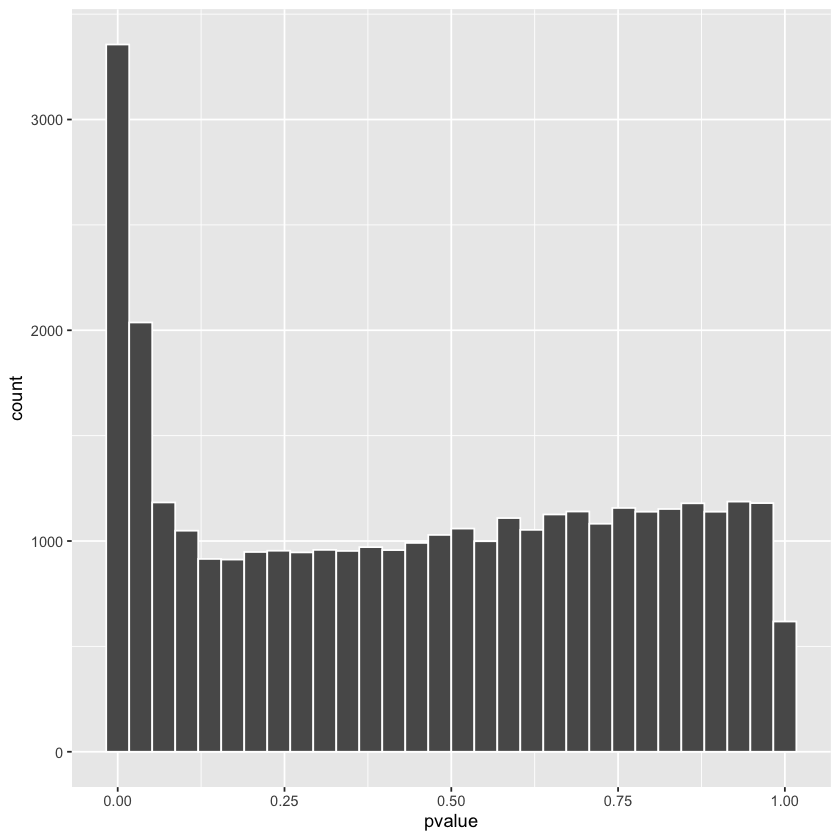

In [22]:
res_shrink %>%
  filter(baseMean > 1) %>%
  ggplot(aes(x = pvalue)) + 
  geom_histogram(col = "white")